### Setup

Notes:
1. Probably could use CDS rates as a pretty solid indicator but limited data. Also, deltas in credit ratings.
2. Lack of reporting is probably a pretty solid indicator for higher regime turnover since reduced transparency is highly correlated with many things that reduce durability

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats.mstats import winsorize
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [48]:
wb_df = pd.read_csv("P_Data_Extract_From_World_Development_Indicators/6766cabb-d1b8-4a8e-9ce9-0877a6970498_Data.csv")

plty_df = pd.read_excel("POLITY5-PRC.xlsx")

In [3]:
wb_df.head()

,Country Name,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,Afghanistan,AFG,Real interest rate (%),FR.INR.RINR,..,..,..,..,..,..,...,14.3516893380043,12.2525481629518,17.5839381624543,12.1411782956513,..,..,..,..,..,..
1,Afghanistan,AFG,CPIA debt policy rating (1=low to 6=high),IQ.CPA.DEBT.XQ,..,..,..,..,..,..,...,3,3,2.5,2.5,2.5,2.5,2.5,..,1.5,1.5
2,Afghanistan,AFG,"Central government debt, total (% of GDP)",GC.DOD.TOTL.GD.ZS,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
3,Afghanistan,AFG,External debt stocks (% of GNI),DT.DOD.DECT.GN.ZS,..,..,..,..,..,..,...,12.3049882430693,13.4908300391384,14.1470450328557,14.5133427332625,14.6424246274665,13.9496520911751,15.1208585234171,24.7744403222298,..,..
4,Afghanistan,AFG,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,..,..,..,..,..,..,...,7.915,9.011,10.1,11.184,11.206,11.224,11.71,11.934,14.1,14.386


In [4]:
plty_df.head()

,Economy ISO3,Economy Name,Indicator ID,Indicator,Attribute 1,Attribute 2,Attribute 3,Partner,1776,1777,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,AFG,Afghanistan,POLITY5.PRC.autoc,Polity database: Institutionalized Autocracy I...,-,-,-,-,NaN,NaN,...,-66.0,-66.0,-66.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN
1,AFG,Afghanistan,POLITY5.PRC.democ,Polity database: Institutionalized Democracy I...,-,-,-,-,NaN,NaN,...,-66.0,-66.0,-66.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
2,AFG,Afghanistan,POLITY5.PRC.durable,Polity database: Regime Durability Index,-,-,-,-,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,NaN,NaN
3,AFG,Afghanistan,POLITY5.PRC.exconst,Polity database: Executive Constraints Concept,-,-,-,-,NaN,NaN,...,-66.0,-66.0,-66.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN
4,AFG,Afghanistan,POLITY5.PRC.exrec,Polity database: Executive Recruitment Concept,-,-,-,-,NaN,NaN,...,-66.0,-66.0,-66.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN


In [49]:
# ----------------------
# Cleaning wb_df
# ----------------------
# Remove [YRxxxx] text from year columns
wb_df.columns = wb_df.columns.str.replace(r'\s*\[YR\d+\]', '', regex=True)

# Melt wb_df to long format
wb_long_df = wb_df.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    var_name="Year", value_name="Value"
)

# Convert Year to int
wb_long_df["Year"] = pd.to_numeric(wb_long_df["Year"], errors='coerce', downcast='integer')
wb_long_df = wb_long_df.dropna(subset=["Year"])  # drop rows if Year couldn't be converted
wb_long_df["Year"] = wb_long_df["Year"].astype(int)

# Convert Value to numeric
wb_long_df["Value"] = pd.to_numeric(wb_long_df["Value"], errors='coerce')

# Pivot table using mean. If there are non-numeric entries, now they are NaN.
wb_wide_df = wb_long_df.pivot_table(
    index=["Country Code", "Year"],
    columns="Series Name",
    values="Value",
    aggfunc='mean'
).reset_index()

# Rename "Country Code" to "ISO3"
wb_wide_df = wb_wide_df.rename(columns={"Country Code": "ISO3"})

wb_wide_df = wb_wide_df[(wb_wide_df["Year"] >= 1980) & (wb_wide_df["Year"] <= 2020)]


In [50]:
# ----------------------
# Cleaning plty_df
# ----------------------
# Assume plty_df has columns:
# "Economy ISO3", "Economy Name", "Indicator ID", "Indicator", "Attribute 1", "Attribute 2", "Attribute 3", "Partner", and yearly columns like 1776, 1777, ...
plty_long_df = plty_df.melt(
    id_vars=["Economy ISO3", "Economy Name", "Indicator ID", "Indicator", "Attribute 1", "Attribute 2", "Attribute 3", "Partner"],
    var_name="Year", value_name="Indicator_Value"
)

# Rename "Economy ISO3" to "ISO3"
plty_long_df = plty_long_df.rename(columns={"Economy ISO3": "ISO3"})

# Ensure Year is integer
plty_long_df["Year"] = plty_long_df["Year"].astype(int)

# Pivot so each Indicator is a column
plty_pivot_df = plty_long_df.pivot_table(
    index=["ISO3", "Year"],
    columns="Indicator",
    values="Indicator_Value",
    aggfunc='mean'  # If duplicates occur for the same indicator, year, country
).reset_index()

plty_pivot_df = plty_pivot_df[(plty_pivot_df["Year"] >= 1980) & (plty_pivot_df["Year"] <= 2020)]

plty_pivot_df = plty_pivot_df[(plty_pivot_df["Polity database: Combined Polity Score"] >= -10) & (plty_pivot_df["Polity database: Combined Polity Score"] <= 10)]

In [51]:
# ----------------------
# Merge wb_wide_df and plty_pivot_df
# ----------------------
merged_df = pd.merge(wb_wide_df, plty_pivot_df, on=["ISO3", "Year"], how="inner")

# Sort for groupby operations
merged_df = merged_df.sort_values(by=["ISO3", "Year"])

# Create regime_change_next_year variable
merged_df["regime_change_next_year"] = (
    merged_df.groupby("ISO3")["Polity database: Regime Durability Index"]
    .transform(lambda x: (x.shift(-1) < x).astype(int))
)

In [32]:
merged_df.head()

,ISO3,Year,Armed forces personnel (% of total labor force),Battle-related deaths (number of people),CPIA debt policy rating (1=low to 6=high),CPIA fiscal policy rating (1=low to 6=high),"CPIA transparency, accountability, and corruption in the public sector rating (1=low to 6=high)","Central government debt, total (% of GDP)",Control of Corruption: Estimate,External debt stocks (% of GNI),...,Polity database: Institutionalized Autocracy Index,Polity database: Institutionalized Democracy Index,Polity database: Openness of Executive Recruitment,Polity database: Political Competition Concept,Polity database: Regime Durability Index,Polity database: Regulation of Chief Executive Recruitment,Polity database: Regulation of Participation,Polity database: Revised Combined Polity Score (p5),Polity database: The Competitiveness of Participation,regime_change_next_year
0,AFG,1989,NaN,5174.0,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,0.0,4.0,1.0,0.0,2.0,4.0,-8.0,1.0,0
1,AFG,1990,NaN,1478.0,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,0.0,4.0,1.0,1.0,2.0,4.0,-8.0,1.0,0
2,AFG,1991,1.500226,3302.0,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,0.0,4.0,1.0,2.0,2.0,4.0,-8.0,1.0,1
3,AFG,1996,10.124145,3177.0,NaN,NaN,NaN,NaN,-1.291705,NaN,...,7.0,0.0,0.0,1.0,0.0,1.0,4.0,-7.0,1.0,0
4,AFG,1997,9.809219,6396.0,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,0.0,0.0,1.0,1.0,1.0,4.0,-7.0,1.0,0


### Feature Engineering

In [52]:
target = "regime_change_next_year"

# Initial features
features = [
    'Real interest rate (%)',
    'CPIA debt policy rating (1=low to 6=high)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Inflation, GDP deflator (annual %)',
    'GDP growth (annual %)',
    'Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)',
    'Central government debt, total (% of GDP)',
    'Real effective exchange rate index (2010 = 100)',
    'External debt stocks (% of GNI)',
    'Armed forces personnel (% of total labor force)',
    'Battle-related deaths (number of people)',
    'Control of Corruption: Estimate',
    'CPIA fiscal policy rating (1=low to 6=high)',
    'CPIA transparency, accountability, and corruption in the public sector rating (1=low to 6=high)',
    'Military expenditure (% of GDP)',
    'GDP (constant 2015 US$)'
]

merged_df = merged_df.copy()

# Create YoY features
merged_df['YoY_Unemployment'] = (merged_df.groupby('ISO3')['Unemployment, total (% of total labor force) (modeled ILO estimate)']
                                 .transform(lambda x: x - x.shift(1)))

merged_df['YoY_Inflation'] = (merged_df.groupby('ISO3')['Inflation, GDP deflator (annual %)']
                              .transform(lambda x: x - x.shift(1)))

merged_df['Delta_REER'] = (merged_df.groupby('ISO3')['Real effective exchange rate index (2010 = 100)']
                           .transform(lambda x: x - x.shift(1)))

# Create the misery index = YoY_Inflation + YoY_Unemployment
merged_df['Misery_index'] = merged_df['YoY_Inflation'] + merged_df['YoY_Unemployment']

# Create Debt-GDP interaction
merged_df['Debt_GDP_interaction'] = merged_df['Central government debt, total (% of GDP)'] * merged_df['GDP growth (annual %)']

# Create RealRate-Inflation interaction
merged_df['RealRate_Inflation_interaction'] = merged_df['Real interest rate (%)'] * merged_df['Inflation, GDP deflator (annual %)']

engineered_features = features + [
    'YoY_Unemployment',
    'YoY_Inflation',
    'Delta_REER',
    'Misery_index',
    'Debt_GDP_interaction',
    'RealRate_Inflation_interaction'
]

# Rating features to handle like CPIA
rating_features = [
    'CPIA debt policy rating (1=low to 6=high)',
    'CPIA fiscal policy rating (1=low to 6=high)',
    'CPIA transparency, accountability, and corruption in the public sector rating (1=low to 6=high)'
]
for rating_col in rating_features:
    merged_df[rating_col] = merged_df[rating_col].fillna(0)

# Columns to impute by median (exclude rating features)
columns_to_impute = [col for col in engineered_features if col not in rating_features]

for col in columns_to_impute:
    year_median = merged_df.groupby('Year')[col].transform('median')
    merged_df[col] = merged_df[col].fillna(year_median)

# Create missingness flags for all engineered features if not already present
for col in engineered_features:
    missing_flag = f"{col}_missing"
    if missing_flag not in merged_df.columns:
        merged_df[missing_flag] = merged_df[col].isna().astype(int)

# Drop any remaining rows with NA
merged_df = merged_df.dropna()

# Final feature list
final_features = engineered_features + [f"{col}_missing" for col in engineered_features]

X = merged_df[final_features]
y = merged_df[target].astype(int)

In [53]:
X

,Real interest rate (%),CPIA debt policy rating (1=low to 6=high),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Inflation, GDP deflator (annual %)",GDP growth (annual %),"Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)","Central government debt, total (% of GDP)",Real effective exchange rate index (2010 = 100),External debt stocks (% of GNI),Armed forces personnel (% of total labor force),...,CPIA fiscal policy rating (1=low to 6=high)_missing,"CPIA transparency, accountability, and corruption in the public sector rating (1=low to 6=high)_missing",Military expenditure (% of GDP)_missing,GDP (constant 2015 US$)_missing,YoY_Unemployment_missing,YoY_Inflation_missing,Delta_REER_missing,Misery_index_missing,Debt_GDP_interaction_missing,RealRate_Inflation_interaction_missing
3,8.091711,0.0,7.941,8.282713,4.312142,47.856,46.480331,103.537697,56.471936,10.124145,...,0,0,0,0,0,0,0,0,0,0
5,10.004352,0.0,7.941,6.078163,3.789120,47.789,56.156167,98.913079,59.497552,8.860659,...,0,0,0,0,0,0,0,0,0,0
7,5.771115,0.0,7.955,6.468815,4.214380,47.795,56.441136,93.172926,60.875742,8.510821,...,0,0,0,0,0,0,0,0,0,0
8,14.351689,3.0,7.915,0.566945,2.724543,48.268,47.976170,99.878750,12.304988,3.751983,...,0,0,0,0,0,0,0,0,0,0
9,12.252548,3.0,9.011,2.447563,1.451315,48.358,49.742210,96.837301,13.490830,3.724272,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,8.787605,2.0,4.774,0.624974,1.484543,66.979,47.976170,99.878750,48.319674,0.967992,...,0,0,0,0,0,0,0,0,0,0
5735,8.144427,2.0,5.383,0.367420,2.023650,67.038,49.742210,96.837301,55.138417,0.952633,...,0,0,0,0,0,0,0,0,0,0
5736,4.998563,2.0,5.893,2.014095,0.900955,67.087,49.853618,97.351287,64.027580,0.935188,...,0,0,0,0,0,0,0,0,0,0
5737,-64.281571,2.0,6.347,199.324941,4.080264,67.093,52.798689,96.904922,80.635048,0.920629,...,0,0,0,0,0,0,0,0,0,0


Correlation Matrix:
                                                    Real interest rate (%)  \
Real interest rate (%)                                            1.000000   
CPIA debt policy rating (1=low to 6=high)                         0.057838   
Unemployment, total (% of total labor force) (m...                0.000256   
Inflation, GDP deflator (annual %)                               -0.238266   
GDP growth (annual %)                                            -0.019668   
Labor force participation rate, total (% of tot...                0.037434   
Central government debt, total (% of GDP)                         0.031468   
Real effective exchange rate index (2010 = 100)                  -0.027143   
External debt stocks (% of GNI)                                   0.075473   
Armed forces personnel (% of total labor force)                  -0.031080   
Battle-related deaths (number of people)                          0.016563   
Control of Corruption: Estimate             

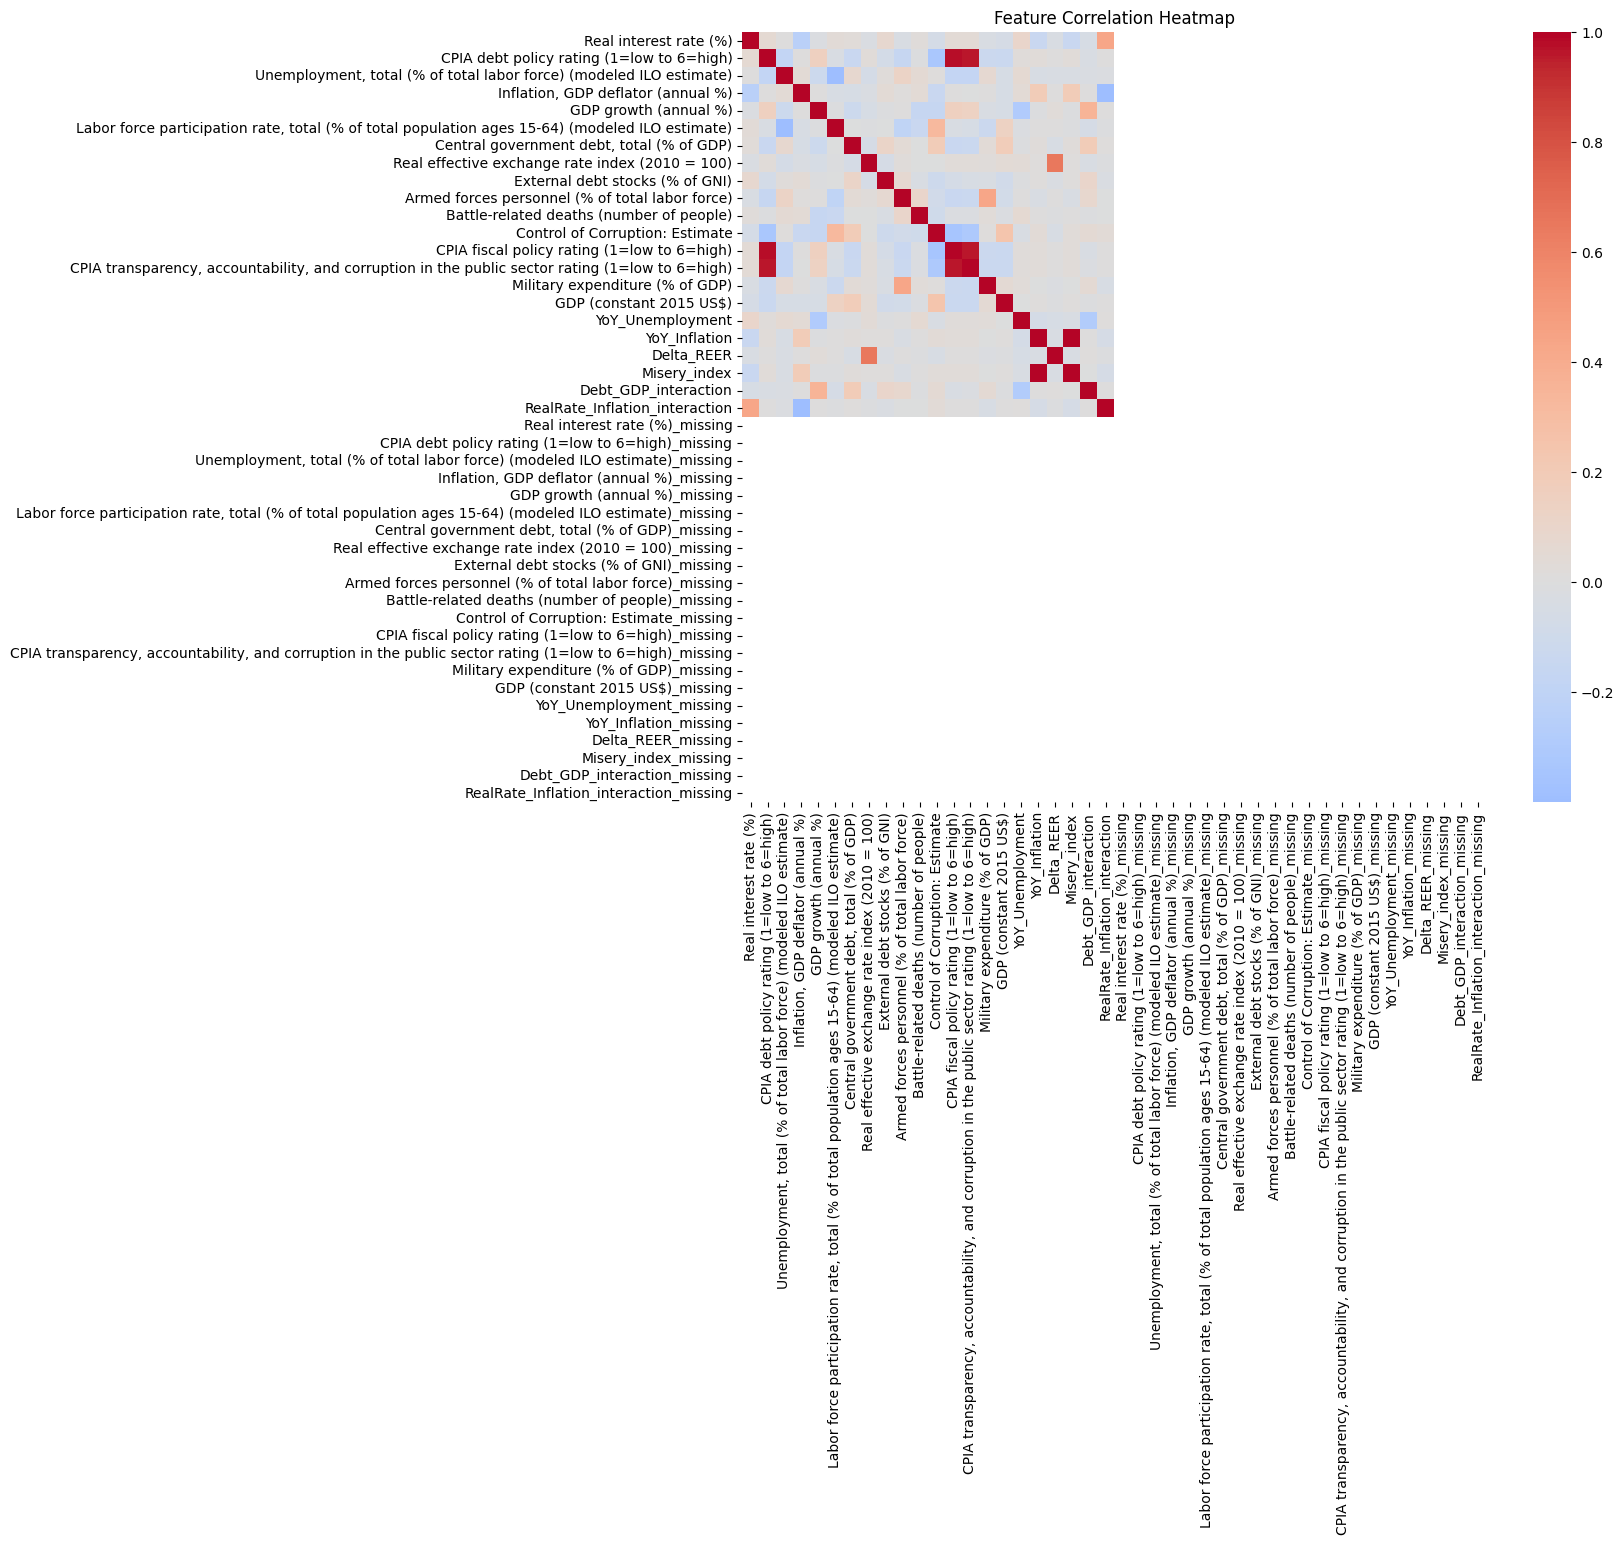

In [54]:
# 1. Correlation Analysis
cor_matrix = X.corr()

# Print correlation matrix
print("Correlation Matrix:")
print(cor_matrix)

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

Explained Variance Ratios:
PC1: 0.1516
PC2: 0.1005
PC3: 0.0861
PC4: 0.0769
PC5: 0.0761
PC6: 0.0683
PC7: 0.0562
PC8: 0.0524
PC9: 0.0500
PC10: 0.0443
PC11: 0.0371
PC12: 0.0345
PC13: 0.0303
PC14: 0.0297
PC15: 0.0251
PC16: 0.0238
PC17: 0.0207
PC18: 0.0191
PC19: 0.0147
PC20: 0.0016
PC21: 0.0009
PC22: 0.0004
PC23: 0.0000
PC24: 0.0000
PC25: 0.0000
PC26: 0.0000
PC27: 0.0000
PC28: 0.0000
PC29: 0.0000
PC30: 0.0000
PC31: 0.0000
PC32: 0.0000
PC33: 0.0000
PC34: 0.0000
PC35: 0.0000
PC36: 0.0000
PC37: 0.0000
PC38: 0.0000
PC39: 0.0000
PC40: 0.0000
PC41: 0.0000
PC42: 0.0000
PC43: 0.0000
PC44: 0.0000

Cumulative Explained Variance:
PCs 1 to 1: 0.1516
PCs 1 to 2: 0.2521
PCs 1 to 3: 0.3382
PCs 1 to 4: 0.4151
PCs 1 to 5: 0.4911
PCs 1 to 6: 0.5594
PCs 1 to 7: 0.6156
PCs 1 to 8: 0.6680
PCs 1 to 9: 0.7180
PCs 1 to 10: 0.7623
PCs 1 to 11: 0.7994
PCs 1 to 12: 0.8339
PCs 1 to 13: 0.8642
PCs 1 to 14: 0.8938
PCs 1 to 15: 0.9189
PCs 1 to 16: 0.9427
PCs 1 to 17: 0.9634
PCs 1 to 18: 0.9825
PCs 1 to 19: 0.9971
PCs 1 t

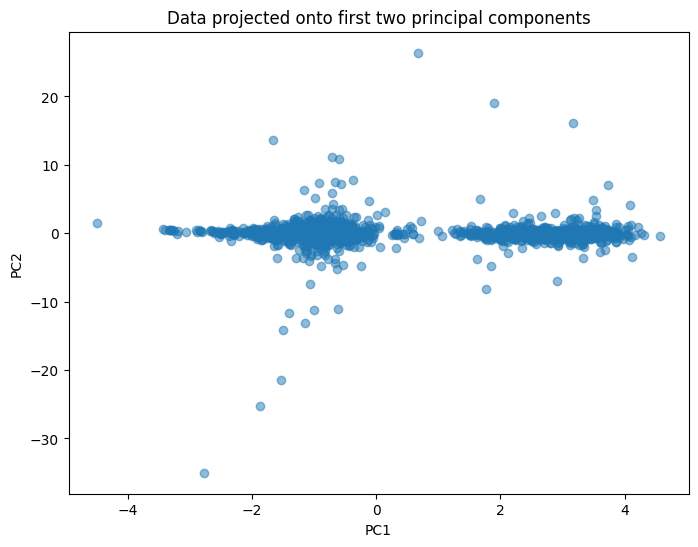

In [55]:
# 2. PCA Analysis
# Standardize the features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:")
for i, var in enumerate(explained_variance, start=1):
    print(f"PC{i}: {var:.4f}")

# If you want to determine how many components to keep,
# you might look at the cumulative explained variance:
cumulative_variance = np.cumsum(explained_variance)
print("\nCumulative Explained Variance:")
for i, cum_var in enumerate(cumulative_variance, start=1):
    print(f"PCs 1 to {i}: {cum_var:.4f}")

# Optional: Choose a number of components (e.g., enough to explain ~90% variance)
# and transform the data into that principal component space
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"\nNumber of components to explain at least 90% variance: {n_components}")

pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_scaled)

# X_reduced now contains the transformed data in the reduced dimensionality space.
# You can use X_reduced for downstream modeling if desired.

# Optionally, visualize the first two principal components:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Data projected onto first two principal components")
plt.show()

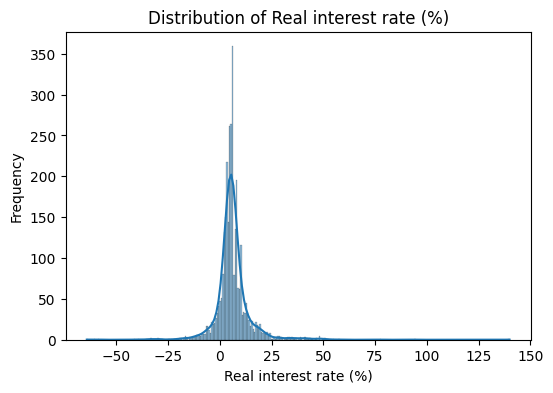

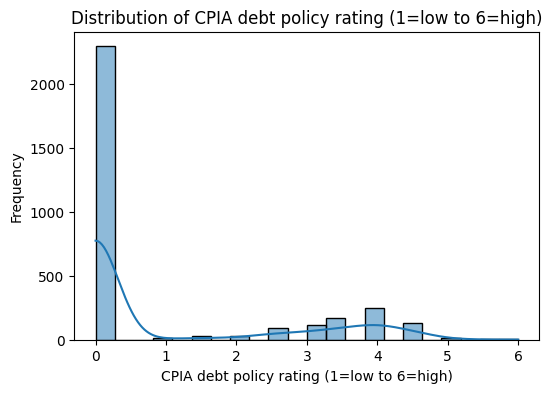

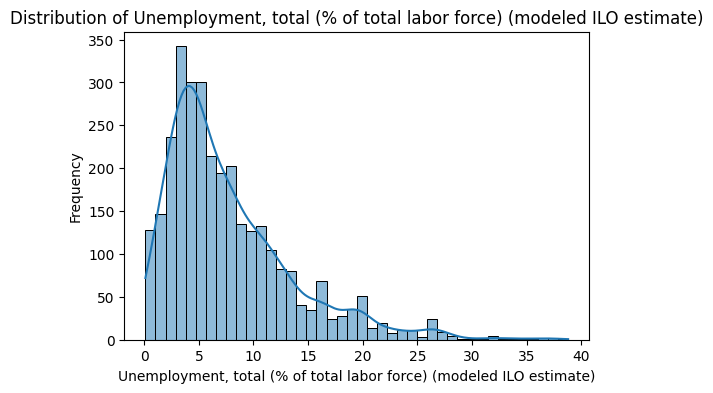

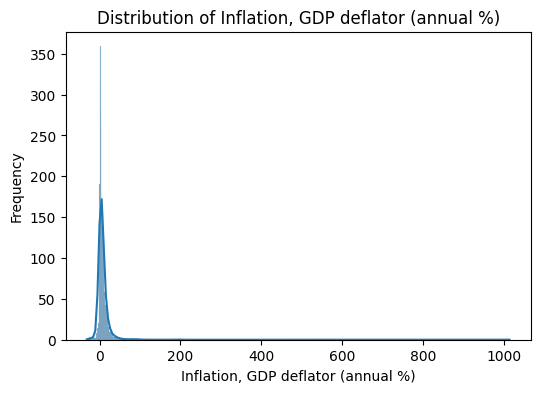

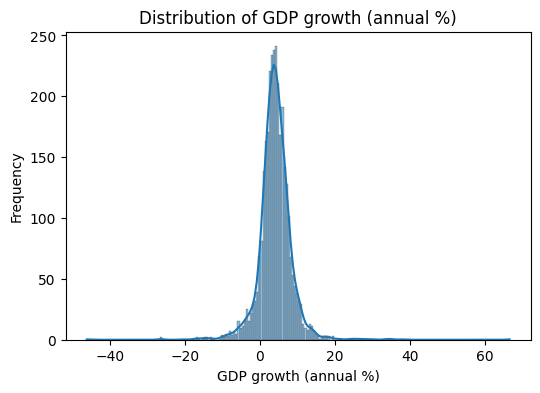

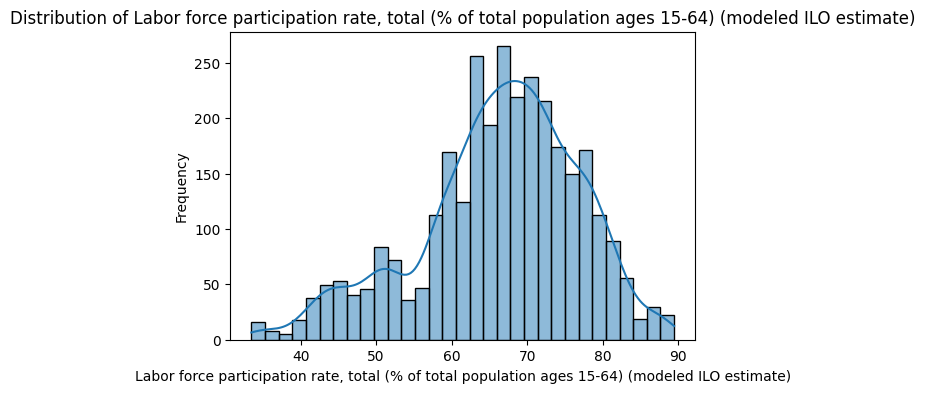

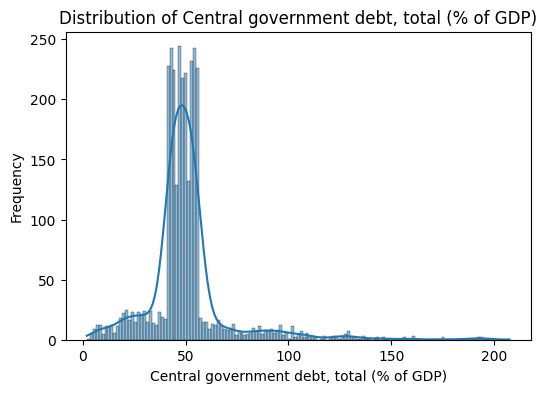

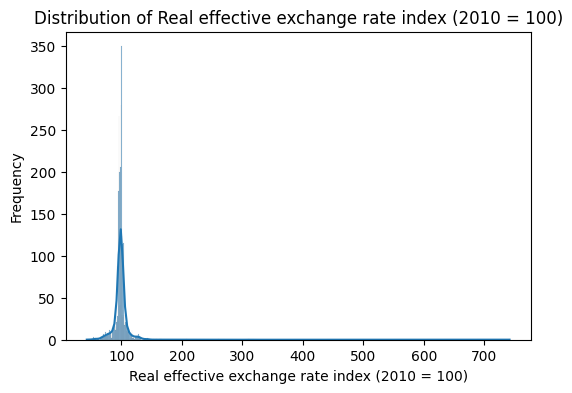

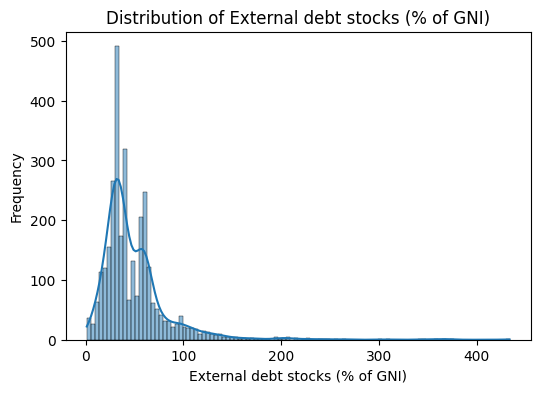

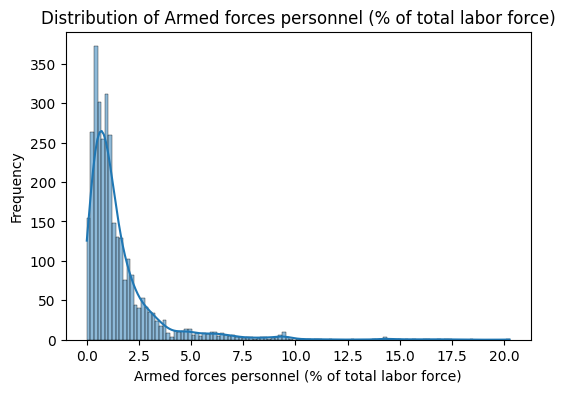

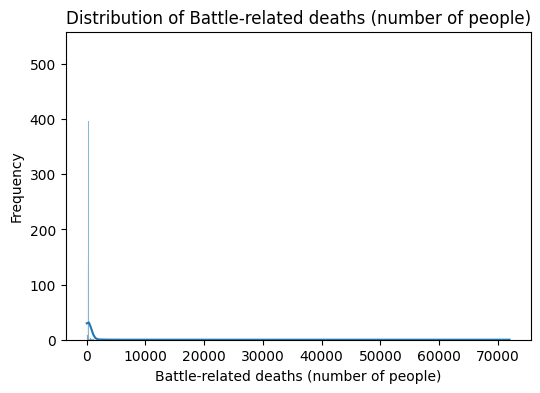

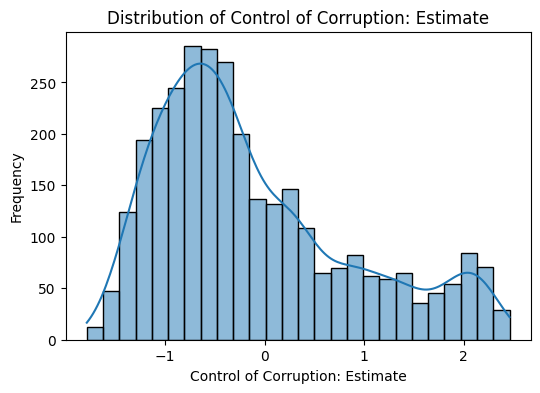

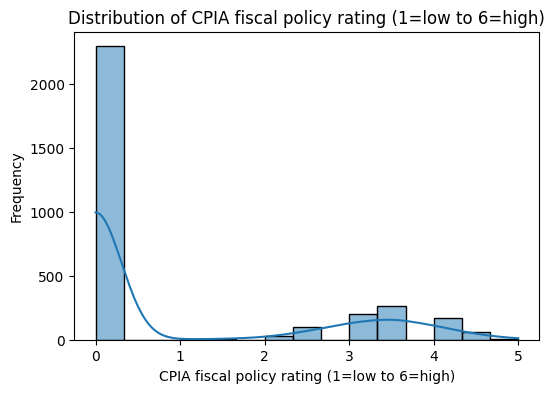

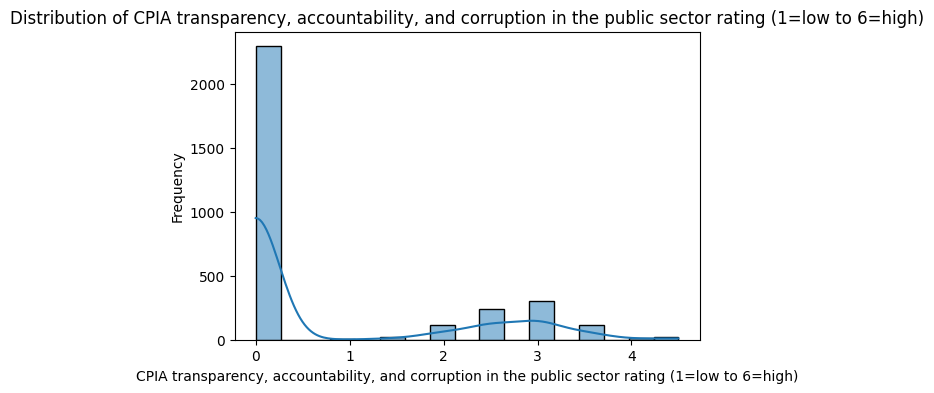

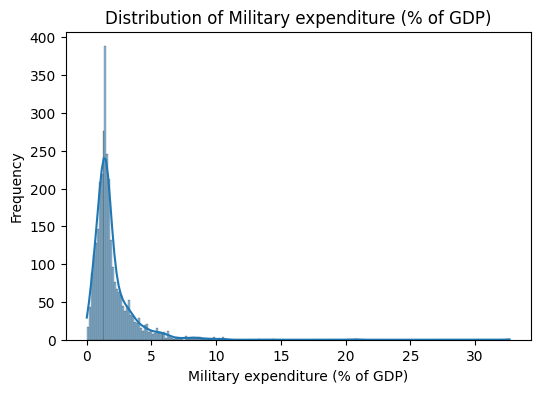

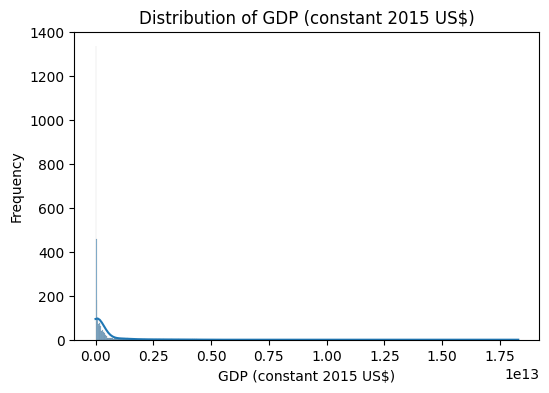

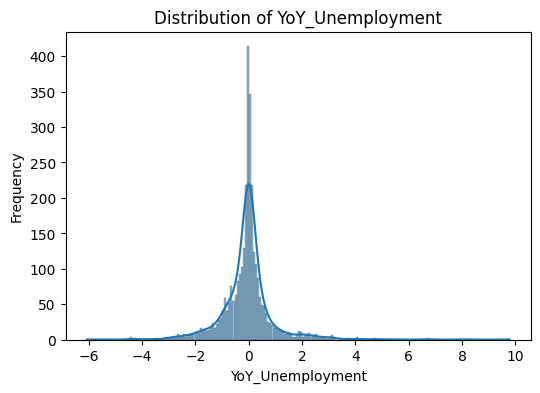

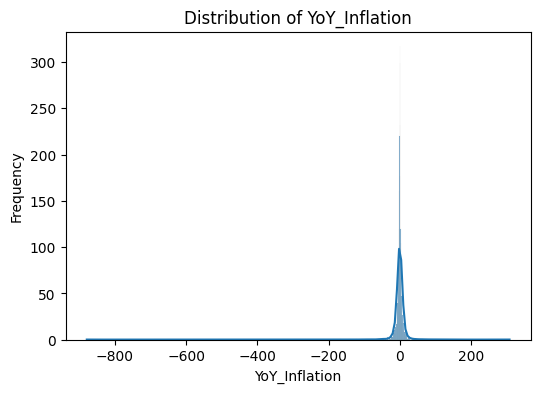

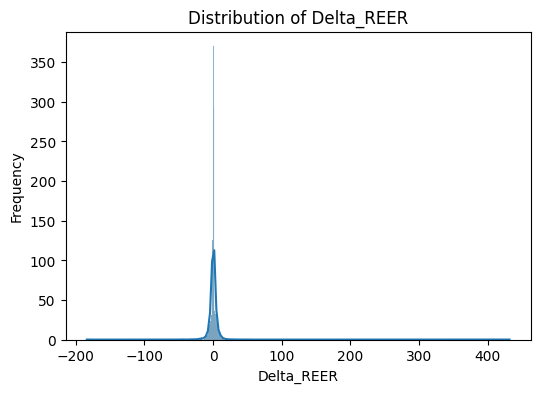

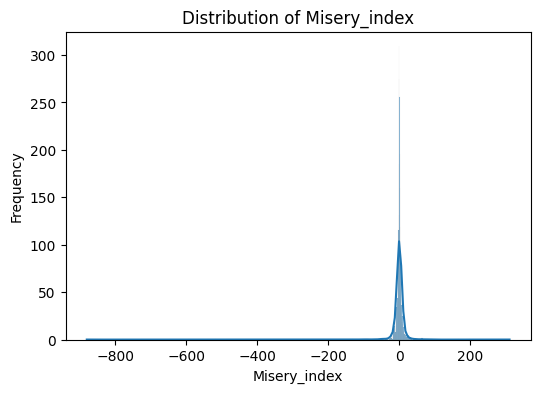

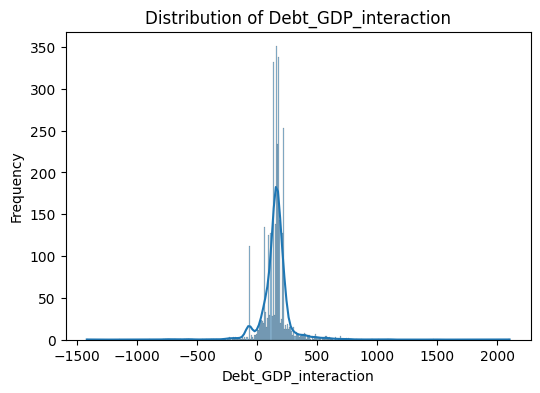

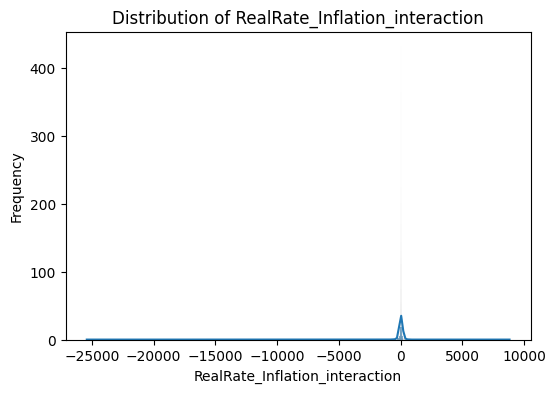

In [58]:
# 1. Distribution Analysis
# Plot histograms for each feature
for col in X[engineered_features]:
    plt.figure(figsize=(6,4))
    sns.histplot(X[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [59]:
X = merged_df[engineered_features].copy()

# Updated log transform columns
log_transform_cols = [
    'Inflation, GDP deflator (annual %)',
    'Central government debt, total (% of GDP)',
    'Real effective exchange rate index (2010 = 100)',
    'External debt stocks (% of GNI)',
    'Armed forces personnel (% of total labor force)',
    'Battle-related deaths (number of people)',
    'Military expenditure (% of GDP)',
    'GDP (constant 2015 US$)'
]

# Columns that will be robust scaled (previously chosen, remove any now transformed by log)
robust_scale_cols = [
    'YoY_Unemployment',
    'YoY_Inflation',
    'Delta_REER',
    'Misery_index',
    'Debt_GDP_interaction',
    'RealRate_Inflation_interaction'
]
# Ensure none of the log transform columns appear here

# Standard scaling columns:
standard_scale_cols = [
    'Real interest rate (%)',
    'GDP growth (annual %)',
    'Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)',
    'Control of Corruption: Estimate'  # Added for standard scaling
]

# Remove any columns from standard_scale_cols or robust_scale_cols if they were added to log_transform_cols
robust_scale_cols = [c for c in robust_scale_cols if c not in log_transform_cols]
standard_scale_cols = [c for c in standard_scale_cols if c not in log_transform_cols]

# 1. Log Transform
for col in log_transform_cols:
    min_val = X[col].min()
    offset = 1 - min_val if min_val <= 0 else 0
    X.loc[:, col] = np.log(X[col] + offset + 1)

# 2. Winsorize the robust scale cols
def winsorize_series(s, lower_quantile=0.01, upper_quantile=0.99):
    lower = s.quantile(lower_quantile)
    upper = s.quantile(upper_quantile)
    return s.clip(lower, upper)

for col in robust_scale_cols:
    X.loc[:, col] = winsorize_series(X[col])

# 3. Robust scaling
if robust_scale_cols:
    robust_scaler = RobustScaler()
    X.loc[:, robust_scale_cols] = robust_scaler.fit_transform(X[robust_scale_cols])

# 4. Standard scaling
if standard_scale_cols:
    standard_scaler = StandardScaler()
    X.loc[:, standard_scale_cols] = standard_scaler.fit_transform(X[standard_scale_cols])

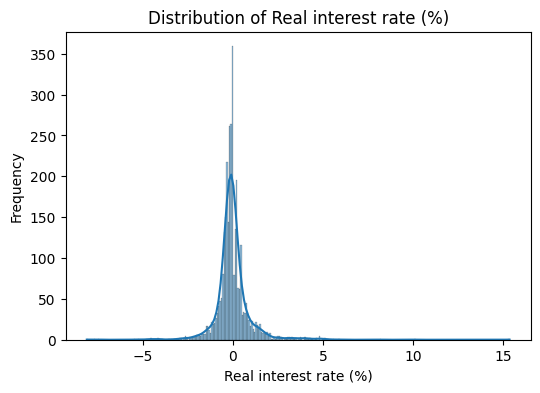

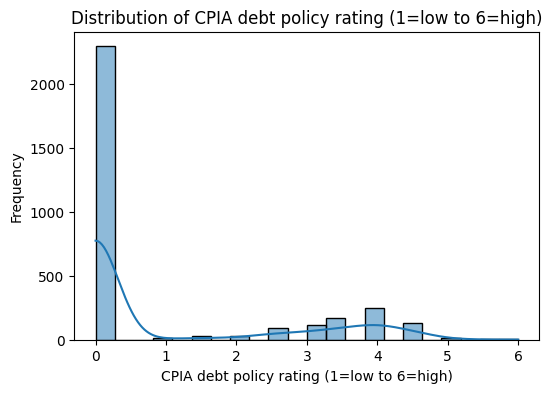

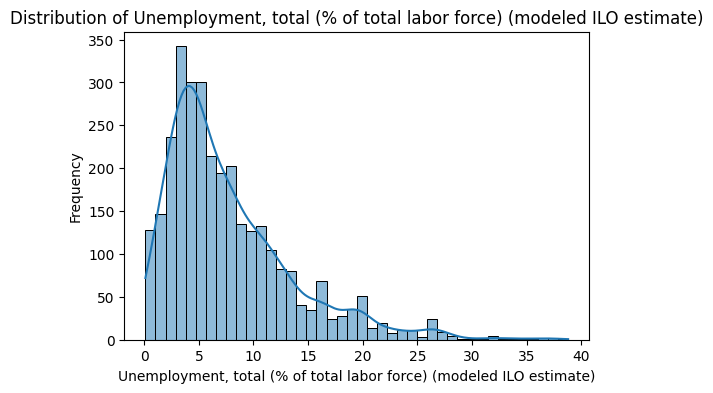

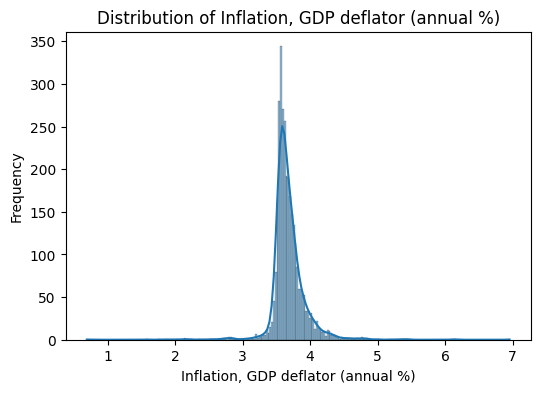

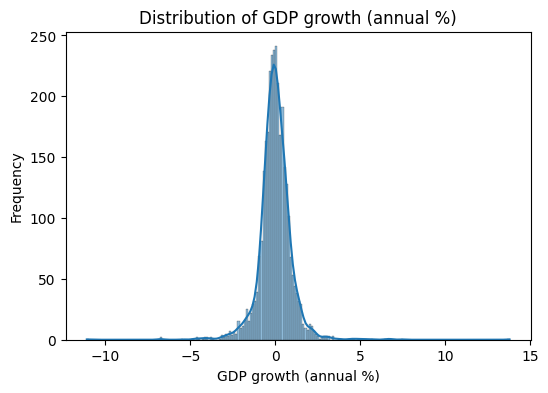

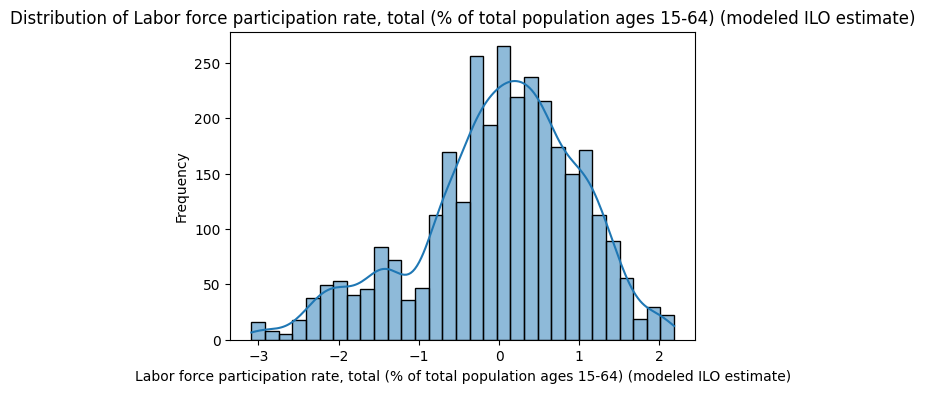

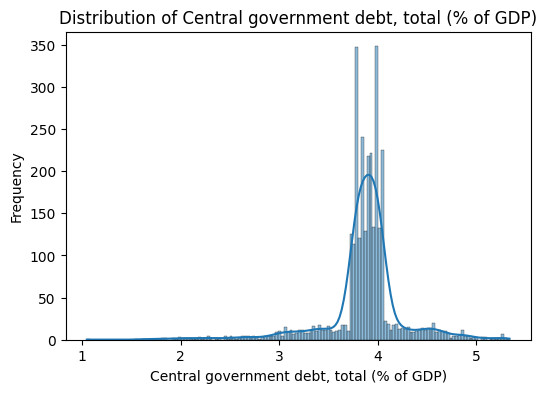

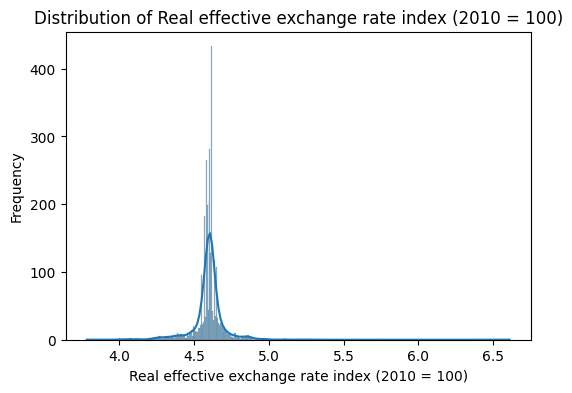

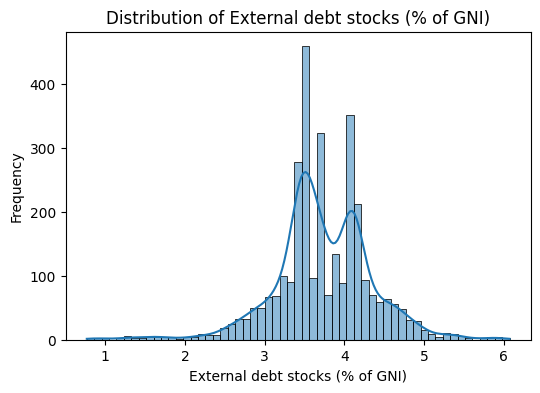

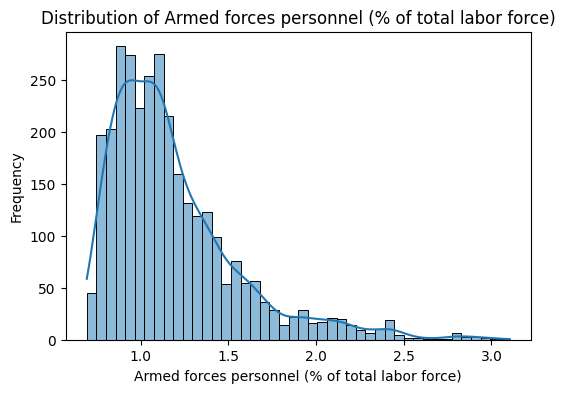

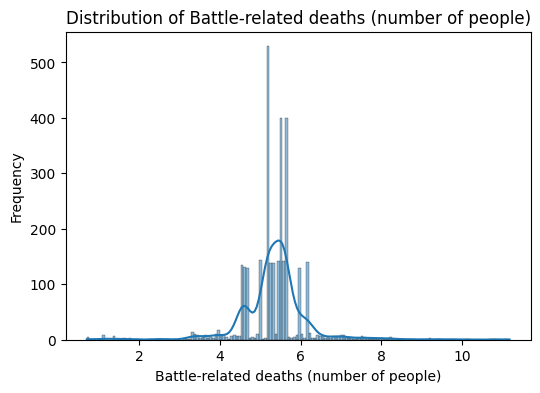

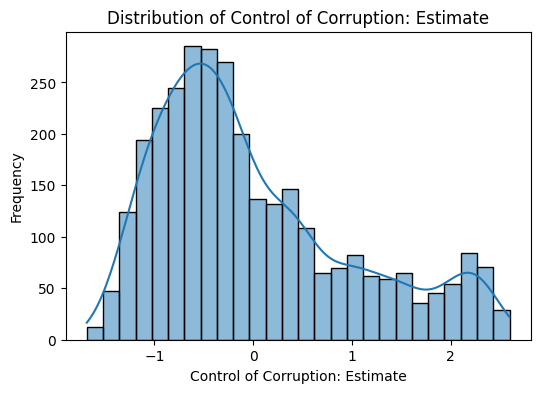

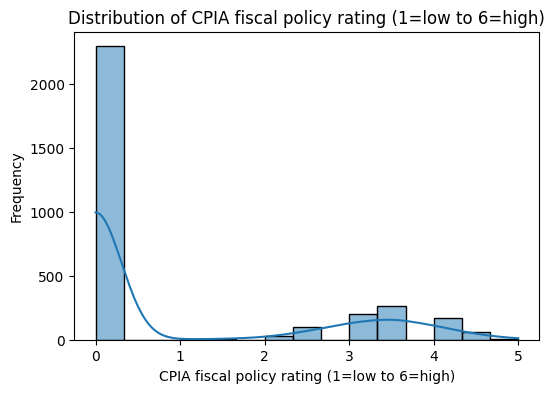

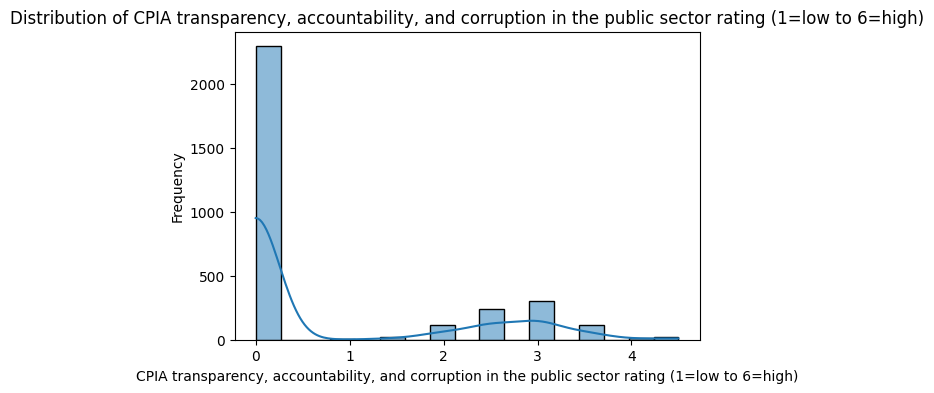

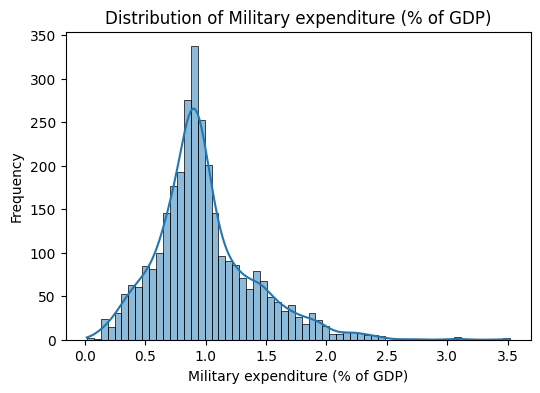

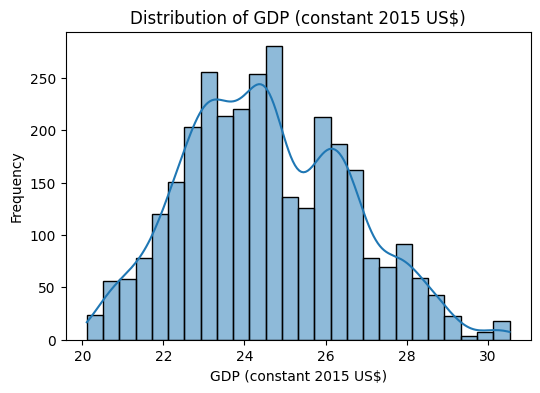

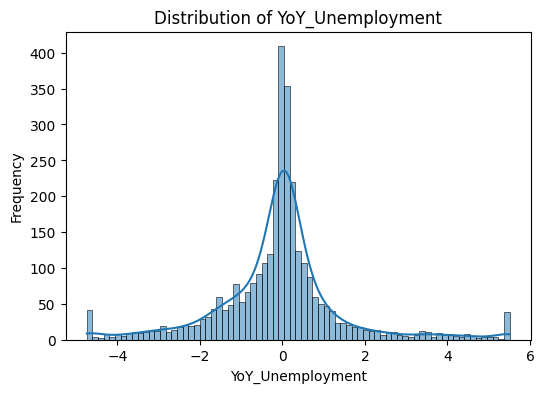

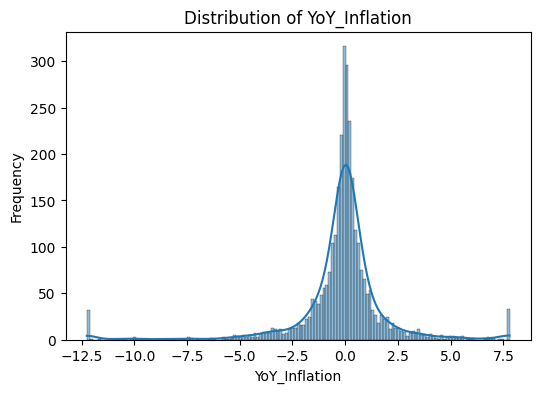

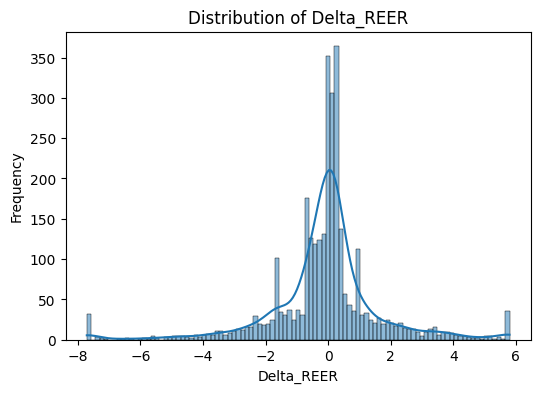

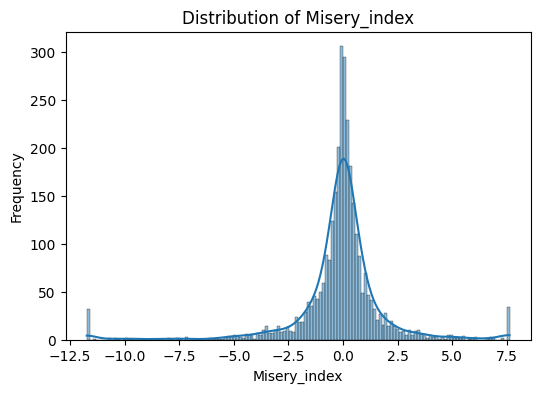

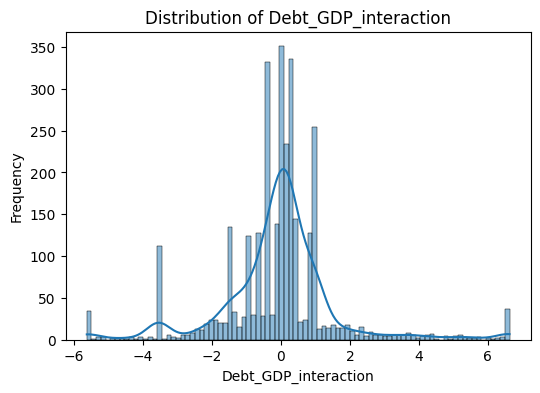

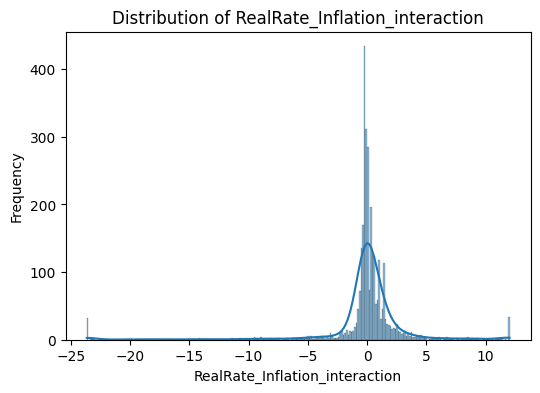

In [60]:
# 1. Distribution Analysis
# Plot histograms for each feature
for col in X[engineered_features]:
    plt.figure(figsize=(6,4))
    sns.histplot(X[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [61]:
# Get a list of all countries
all_countries = merged_df['ISO3'].unique()

# Pivot to get a Year x Country matrix
year_country_df = (
    merged_df.pivot_table(
        index='Year',
        columns='ISO3',
        values='regime_change_next_year',
        aggfunc='max'  # If multiple rows per country-year, take max (0 or 1)
    ).fillna(0)  # Fill missing values with 0 (no regime change recorded)
)

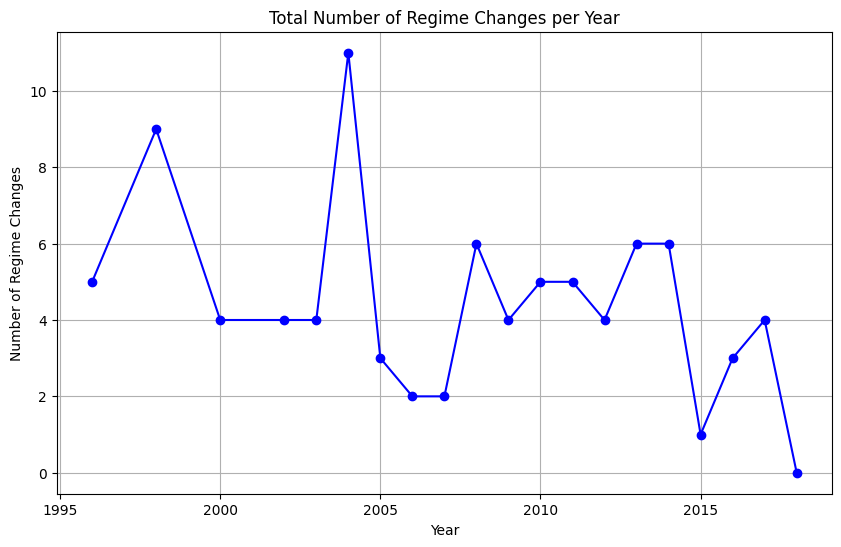

In [66]:
# Aggregate regime changes by year
yearly_changes = merged_df.groupby('Year')['regime_change_next_year'].sum()

# Create a line plot
plt.figure(figsize=(10,6))
yearly_changes.plot(kind='line', marker='o', color='blue')
plt.title("Total Number of Regime Changes per Year")
plt.xlabel("Year")
plt.ylabel("Number of Regime Changes")
plt.grid(True)
plt.show()

In [67]:
features = [
    'GDP growth (annual %)',
    'Inflation, GDP deflator (annual %)',
    'Real interest rate (%)',
    'Central government debt, total (% of GDP)'
]

years = merged_df['Year'].unique()

# Dictionary to store results per year
yearly_cluster_results = {}

for yr in years:
    # Create a DataFrame for that specific year
    year_data = merged_df[merged_df['Year'] == yr].copy()
    
    # Ensure we have all needed columns: features + regime_change_next_year + ISO3
    needed_cols = features + ['regime_change_next_year', 'ISO3']
    # Drop rows with missing values in any of the chosen features
    year_data = year_data.dropna(subset=features)
    
    # If fewer than 2 rows remain, clustering doesn't make sense
    if len(year_data) < 2:
        continue

    # Extract the matrix of features
    X_year = year_data[features].values
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_year)

    # Perform clustering
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels to the DataFrame
    year_data['Cluster'] = cluster_labels

    # Compute averages of the chosen features + regime_change_next_year by cluster
    avg_by_cluster = year_data.groupby('Cluster')[features + ['regime_change_next_year']].mean()
    
    # Store assignments and averages for this year
    yearly_cluster_results[yr] = {
        'assignments': year_data[['ISO3', 'Cluster']],
        'averages': avg_by_cluster
    }

# If you want to consolidate the assignments for all years into a single DataFrame:
all_assignments = []
for yr, results in yearly_cluster_results.items():
    df = results['assignments'].copy()
    df['Year'] = yr
    all_assignments.append(df)

assignments_df = pd.concat(all_assignments, ignore_index=True)


<Figure size 1000x600 with 0 Axes>

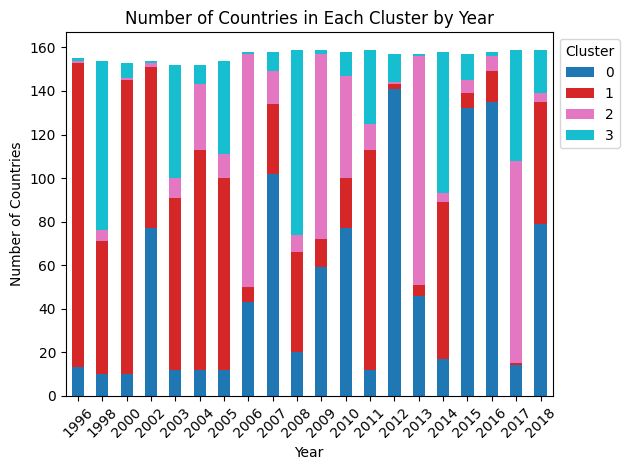

In [68]:
# Assuming you have `assignments_df` with columns: ISO3, Year, Cluster
cluster_counts = assignments_df.groupby(['Year', 'Cluster']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', stacked=True, colormap='tab10')
plt.title("Number of Countries in Each Cluster by Year")
plt.xlabel("Year")
plt.ylabel("Number of Countries")
plt.xticks(rotation=45)
plt.legend(title="Cluster", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

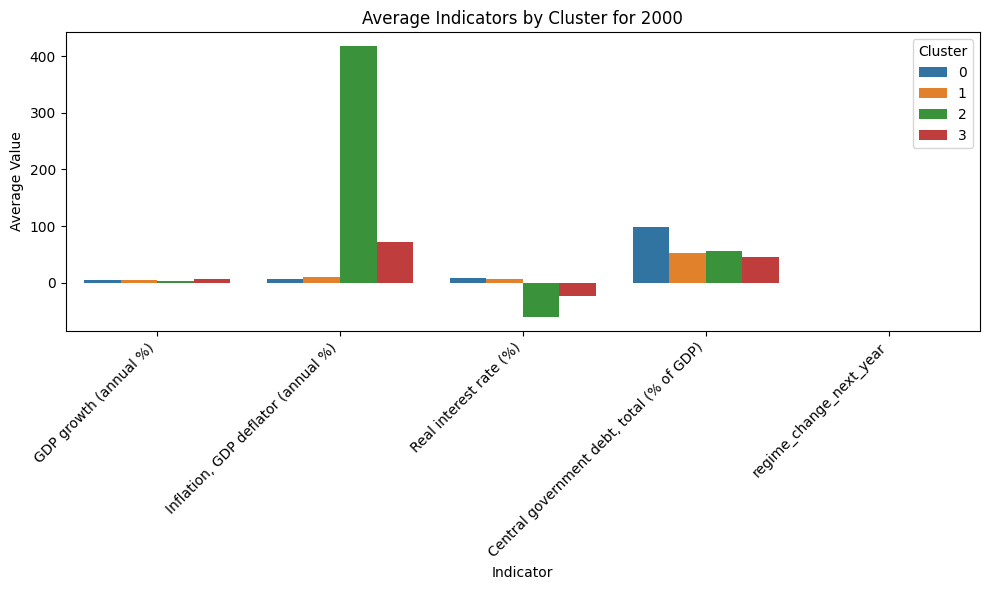

In [69]:
year_of_interest = 2000  # choose the year you want to inspect
averages = yearly_cluster_results[year_of_interest]['averages']

# averages is a DataFrame indexed by Cluster with columns = features + 'regime_change_next_year'
# Melt the DataFrame so each row is a (Cluster, Variable, Value)
melted = averages.reset_index().melt(id_vars='Cluster', var_name='Variable', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(x='Variable', y='Value', hue='Cluster', data=melted, palette='tab10')
plt.title(f"Average Indicators by Cluster for {year_of_interest}")
plt.xlabel("Indicator")
plt.ylabel("Average Value")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

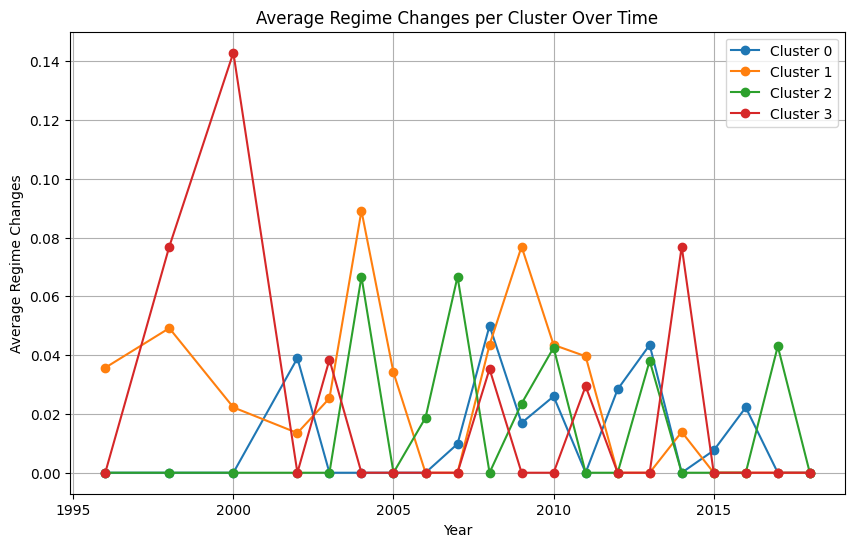

In [70]:
# Construct a DataFrame with average regime_change_next_year per cluster-year
avg_changes_per_cluster = []
for yr, results in yearly_cluster_results.items():
    df = results['averages'][['regime_change_next_year']].copy()
    df['Year'] = yr
    avg_changes_per_cluster.append(df.reset_index())  # Cluster as column, Year as column

avg_changes_df = pd.concat(avg_changes_per_cluster, ignore_index=True)

plt.figure(figsize=(10,6))
for cl in avg_changes_df['Cluster'].unique():
    subset = avg_changes_df[avg_changes_df['Cluster'] == cl]
    subset = subset.sort_values('Year')
    plt.plot(subset['Year'], subset['regime_change_next_year'], marker='o', label=f'Cluster {cl}')

plt.title("Average Regime Changes per Cluster Over Time")
plt.xlabel("Year")
plt.ylabel("Average Regime Changes")
plt.grid(True)
plt.legend()
plt.show()

### Models

In [71]:
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [72]:
# Split data into train and test sets
# Stratify to maintain class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check class distribution before SMOTE
print("Original training set class distribution:")
print(pd.Series(y_train).value_counts())

# Initialize SMOTE
sm = SMOTE(random_state=42)

# Fit SMOTE on training data only
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Check new class distribution
print("Resampled training set class distribution:")
print(pd.Series(y_train_res).value_counts())

# Train an SVC model on the resampled data
svc_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svc_model.fit(X_train_res, y_train_res)

# Predict probabilities on the test set
y_pred_proba = svc_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print("After SMOTE:")
print("ROC AUC:", roc_auc)
print("Average Precision:", avg_precision)

Original training set class distribution:
regime_change_next_year
0    2434
1      70
Name: count, dtype: int64
Resampled training set class distribution:
regime_change_next_year
0    2434
1    2434
Name: count, dtype: int64
After SMOTE:
ROC AUC: 0.6896929824561403
Average Precision: 0.09939623711054053


In [73]:
best_threshold = 0.0
best_score = -1.0  # Initialize with a low value
metric_values = []

# Define thresholds to check
thresholds = np.linspace(0, 1, 101)  # 0.00, 0.01, 0.02, ... 1.00

for thr in thresholds:
    # Convert predicted probabilities to binary predictions at this threshold
    y_pred = (y_pred_proba >= thr).astype(int)
    
    # Calculate the chosen metric. Here we use F1-score as an example
    # You could also try precision_score, recall_score, or a custom combination.
    score = f1_score(y_test, y_pred)
    metric_values.append((thr, score))
    
    if score > best_score:
        best_score = score
        best_threshold = thr

print("Best threshold: {:.2f}".format(best_threshold))
print("Best F1-score: {:.4f}".format(best_score))

# If desired, inspect how precision and recall change at the best threshold:
y_pred_best = (y_pred_proba >= best_threshold).astype(int)
prec = precision_score(y_test, y_pred_best)
rec = recall_score(y_test, y_pred_best)
print("Precision at best threshold: {:.4f}".format(prec))
print("Recall at best threshold: {:.4f}".format(rec))

Best threshold: 0.89
Best F1-score: 0.2222
Precision at best threshold: 0.3333
Recall at best threshold: 0.1667


In [74]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Optional: Use SMOTE for imbalanced data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Initialize Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight=None  # Could use 'balanced' if not using SMOTE
)

# Train the model
rf_model.fit(X_train_res, y_train_res)

# Predict probabilities on the test set
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate performance
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print("Random Forest Results:")
print("ROC AUC:", roc_auc)
print("Average Precision:", avg_precision)


Random Forest Results:
ROC AUC: 0.685672514619883
Average Precision: 0.06422792134494684


In [75]:
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_dist, n_iter=20, scoring='average_precision',
    cv=3, random_state=42, n_jobs=-1
)

random_search.fit(X_train_res, y_train_res)
print("Best Params:", random_search.best_params_)

Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': None}


C:\Users\maxla\AppData\Local\Temp\ipykernel_49108\2491735196.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


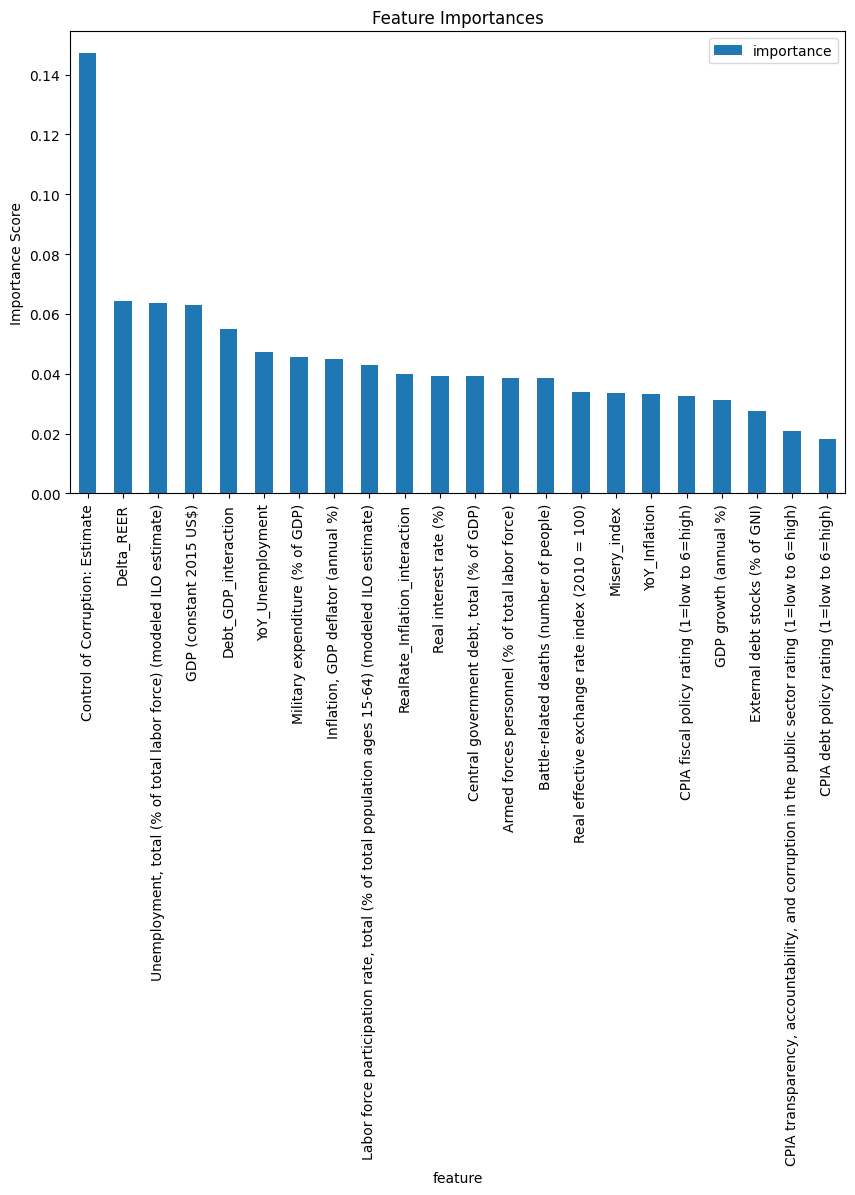

In [76]:
best_rf = random_search.best_estimator_

importances = best_rf.feature_importances_
feature_names = X_train_res.columns  # If X_train_res is a DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
importance_df.plot.bar(x='feature', y='importance', ax=ax)
plt.title('Feature Importances')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

In [77]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score

y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Classification Report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Average Precision Score (consistent with your search metric)
avg_precision = average_precision_score(y_test, y_pred_proba)
print("Average Precision Score:", avg_precision)


Test Accuracy: 0.963258785942492
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       608
           1       0.14      0.06      0.08        18

    accuracy                           0.96       626
   macro avg       0.56      0.52      0.53       626
weighted avg       0.95      0.96      0.96       626

Confusion Matrix:
[[602   6]
 [ 17   1]]
ROC AUC Score: 0.703673245614035
Average Precision Score: 0.06585633851580214


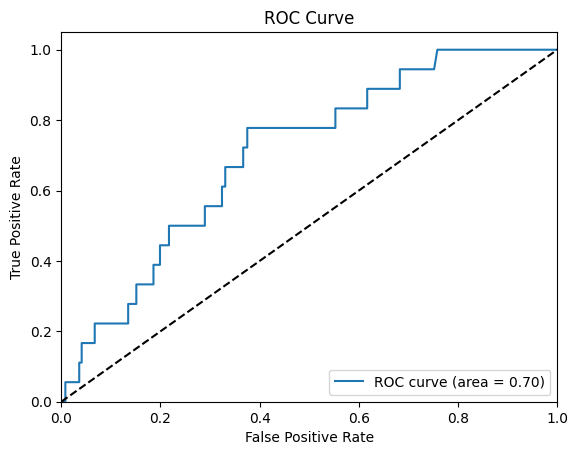

In [78]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Brier Score: 0.04327269739752687
Log Loss: 0.17445752945338575


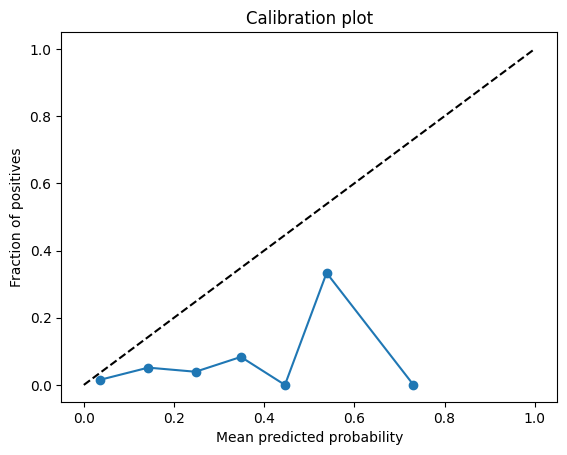

In [79]:
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import brier_score_loss
brier = brier_score_loss(y_test, y_pred_proba)
print("Brier Score:", brier)

from sklearn.metrics import log_loss
ll = log_loss(y_test, y_pred_proba)
print("Log Loss:", ll)

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration plot")
plt.show()


In [90]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(estimator=best_rf, method='sigmoid', cv=3)
calibrated_clf.fit(X_train, y_train)
y_calibrated_proba = calibrated_clf.predict_proba(X_test)[:, 1]
y_calibrated_pred = calibrated_clf.predict(X_test)

Calibrated Brier Score: 0.02777711066143486
Log Loss: 0.1282848509379253


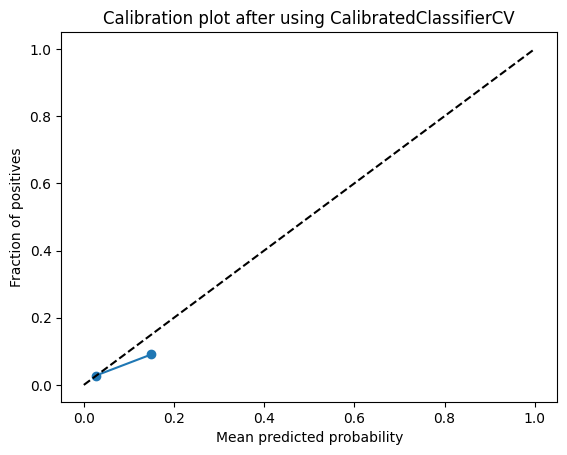

In [91]:
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, y_calibrated_proba)
print("Calibrated Brier Score:", brier)

ll = log_loss(y_test, y_calibrated_proba)
print("Log Loss:", ll)

prob_true, prob_pred = calibration_curve(y_test, y_calibrated_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'k--')
plt.title("Calibration plot after using CalibratedClassifierCV")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.show()

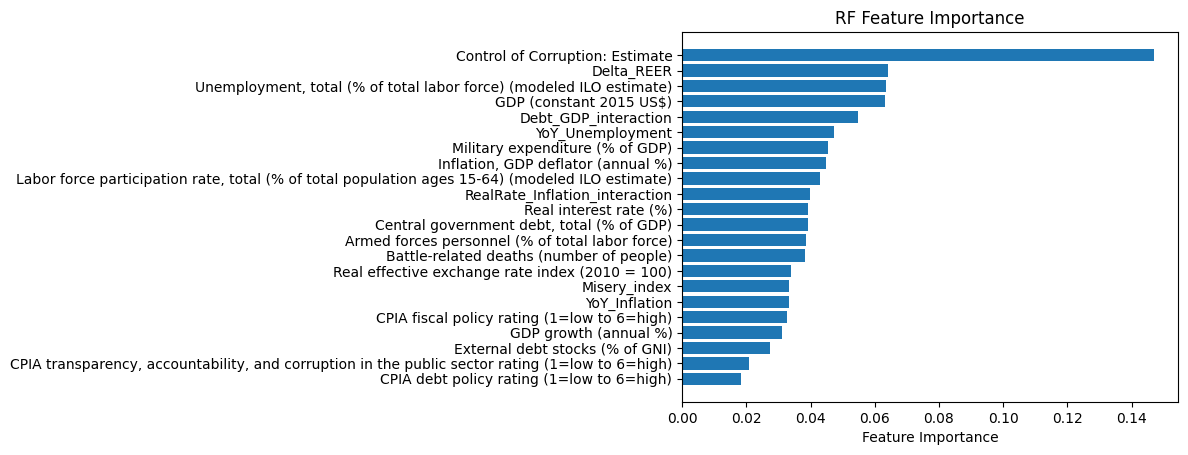

In [92]:
importances = best_rf.feature_importances_
feature_names = X_train.columns
sorted_indices = importances.argsort()

plt.barh(feature_names[sorted_indices], importances[sorted_indices])
plt.xlabel("Feature Importance")
plt.title("RF Feature Importance")
plt.show()


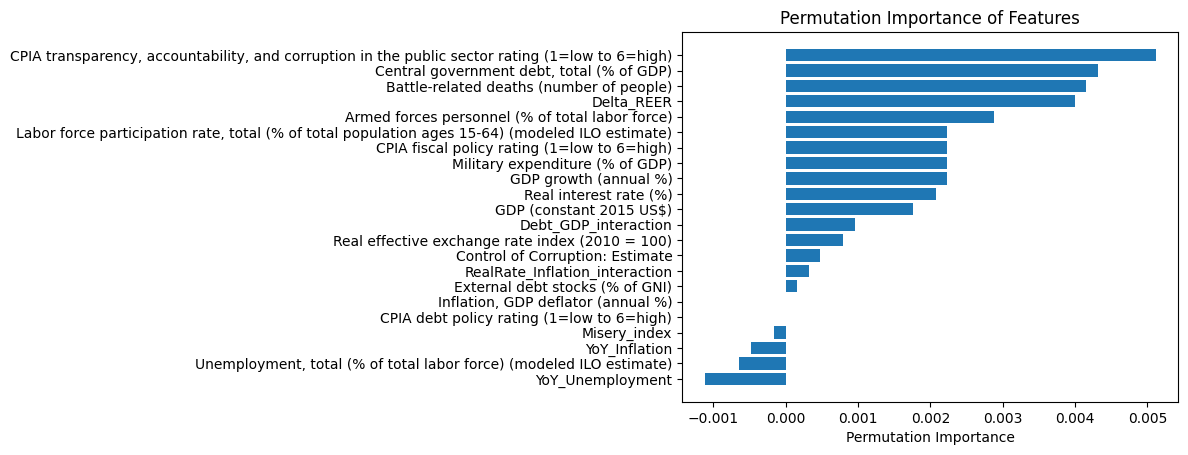

In [93]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance of Features")
plt.show()

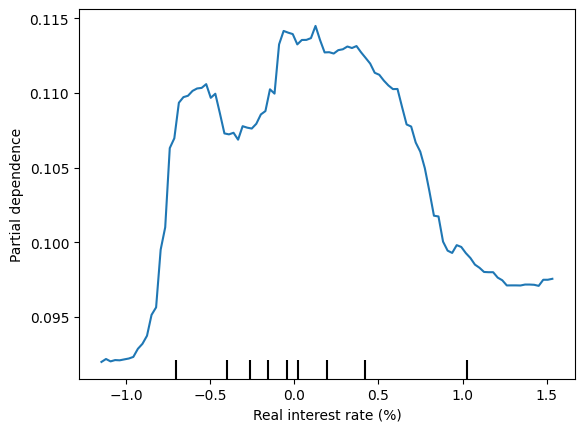

In [96]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(best_rf, X_test, [feature_names[0]])
plt.show()

In [97]:
# Using 'pdpbox' library or manually plotting ICE can help
# pip install pdpbox
from pdpbox import pdp

pdp_goals = pdp.pdp_isolate(model=best_rf, dataset=X_test, model_features=X_test.columns, feature='some_feature')
fig, axes = pdp.pdp_plot(pdp_goals, 'some_feature', plot_pts_dist=True)
plt.show()


ModuleNotFoundError: No module named 'pdpbox'

In [ ]:
import shap

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# For binary classification, shap_values[1] gives explanations for the positive class
shap.summary_plot(shap_values[1], X_test, plot_type="bar")